Link to colab: https://colab.research.google.com/drive/1coTr6n6-E63ga-eHM1dV3p8DpIQuW6n2?usp=sharing

In [ ]:
!wget -O boards_ccrl_1of4.tar 'https://drive.google.com/u/0/uc?id=1wjQfjg8Wee-jVY0gb5L_XXpxCFnc3l_P&confirm=t'
# !wget -O boards_ccrl_2of4.tar 'https://drive.google.com/u/0/uc?id=1WPJgujT75pQFi-WrI2sZIemBBuPJjZSd&confirm=t'
# !wget -O boards_ccrl_3of4.tar 'https://drive.google.com/u/0/uc?id=1CMDXA7OHmK-ZzLkhXV372bV5keVutFeZ&confirm=t'
# !wget -O boards_ccrl_4of4.tar 'https://drive.google.com/u/0/uc?id=1-6VPabZRFnvz-aHJ43TAMuufSIuh4-d4&confirm=t'

!tar -xf boards_ccrl_1of4.tar
# !tar -xf boards_ccrl_2of4.tar
# !tar -xf boards_ccrl_3of4.tar
# !tar -xf boards_ccrl_4of4.tar
!mv boards_ccrl data

!pip install chess

--2023-05-25 20:25:55--  https://drive.google.com/u/0/uc?id=1wjQfjg8Wee-jVY0gb5L_XXpxCFnc3l_P&confirm=t
Resolving drive.google.com (drive.google.com)... 74.125.142.102, 74.125.142.139, 74.125.142.100, ...
Connecting to drive.google.com (drive.google.com)|74.125.142.102|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://drive.google.com/uc?id=1wjQfjg8Wee-jVY0gb5L_XXpxCFnc3l_P&confirm=t [following]
--2023-05-25 20:25:55--  https://drive.google.com/uc?id=1wjQfjg8Wee-jVY0gb5L_XXpxCFnc3l_P&confirm=t
Reusing existing connection to drive.google.com:443.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0g-bo-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/kolp1d3um4j2a5enug7fmfka8a1r3llh/1685046300000/18334911380517025247/*/1wjQfjg8Wee-jVY0gb5L_XXpxCFnc3l_P?uuid=42563cba-fbb7-4b5b-9c3a-68fefce41d85 [following]
--2023-05-25 20:25:55--  https://doc-0g-bo-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7

In [ ]:
!pip install cairosvg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.9/86.9 kB 7.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for cairocffi: filename=cairocffi-1.5.1-py3-none-any.whl size=90523 sha256=d5c44b81ac87710b4f5bdac530b83b2e085814f07ea929764d736c7e942f5c66
  Stored in directory: /root/.cache/pip/wheels/3d/f0/15/e20ff54ef59ec58a08e230bd3874e6f412b09e6a3093f856a7
Successfully built cairocffi


In [ ]:
#@title Setup - Get ChessGNN repo (wait until session restarts)
def get_repo_and_install():
    import subprocess

    assert subprocess.getstatusoutput(f"git clone --depth=1 https://github.com/marcinz99/ChessGNN.git")[0] == 0
    assert subprocess.getstatusoutput(f"pip install -e ChessGNN/")[0] == 0
    exit()

get_repo_and_install()

In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import chess
import os
import gc
import itertools
from tensorflow.data import Dataset
from chessgnn.graphchess.data_ingestion import get_dataset, get_squarewise_features, prepare_features
from chessgnn.chess_utils.connectivity import create_adjacency_matrix
from chessgnn.chess_utils.translations import piece_encoding_to_fen_code
from chessgnn.utils.graph_processing import get_adjacency_matrix_from_edge_list

pd.set_option('display.max_columns', None)
plt.rcParams['figure.dpi'] = 72

In [ ]:
moves = pd.read_parquet("data/boards_0000000.parquet")
moves.memory_usage(deep=True).sum()

545830129

In [ ]:
moves

,game_index,total_len,final_result,latest_move_san,latest_move_uci,possible_moves,possible_captures,latest_move,piece_placement,who_moves_next,halfmove_clock,fullmove_number,ply_counter,state_repetition,lm_capture,lm_check,lm_mate,lm_kingside_castling,lm_queenside_castling,lm_promotion,en_passant_target,K_castling_ability,Q_castling_ability,k_castling_ability,q_castling_ability,place_from,place_to,promoted_to,lm_piece_type,en_passant_target_prev,lm_en_passant,piece_tracking,piece_typing,lm_idx_moved,lm_idx_captured,plies_till_end,future_idx_moved,future_idx_captured,future_move,future_give_check_in_1,future_give_check_in_3,future_give_check_in_5,future_get_checked_in_1,future_get_checked_in_3,future_get_checked_in_5
0,0,64,D,--,----,"[63, 48, 63, 46, 58, 43, 58, 41, 56, 48, 55, 4...",[],[],"[1, 2, 3, 4, 5, 3, 2, 1, 6, 6, 6, 6, 6, 6, 6, ...",w,0,1,0,0,False,False,False,False,False,False,0,True,True,True,True,0,0,,0,0,False,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 3, 2, 1, 6, 6, 6, 6, 6, 6, 6, ...",[],[],64,"[20, 10, 19, 11, 20, 2, 30, 12, 18, 1]",[],"[53, 37]",False,False,False,False,False,False
1,0,64,D,e4,e2e4,"[7, 24, 7, 22, 2, 19, 2, 17, 16, 24, 15, 23, 1...",[],"[53, 37]","[1, 2, 3, 4, 5, 3, 2, 1, 6, 6, 6, 6, 6, 6, 6, ...",b,0,1,1,0,False,False,False,False,False,False,0,True,True,True,True,53,37,,6,0,False,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 3, 2, 1, 6, 6, 6, 6, 6, 6, 6, ...",[20],[],63,"[10, 19, 11, 20, 2, 30, 12, 18, 1, 29]",[],"[11, 19]",False,False,False,False,False,False
2,0,64,D,c6,c7c6,"[63, 48, 63, 46, 63, 53, 62, 17, 62, 26, 62, 3...",[],"[11, 19]","[1, 2, 3, 4, 5, 3, 2, 1, 6, 6, 0, 6, 6, 6, 6, ...",w,0,2,2,0,False,False,False,False,False,False,0,True,True,True,True,11,19,,6,0,False,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 19, 12, 13, 14...","[1, 2, 3, 4, 5, 3, 2, 1, 6, 6, 6, 6, 6, 6, 6, ...",[10],[],62,"[19, 11, 20, 2, 30, 12, 18, 1, 29, 13]",[],"[52, 36]",False,False,False,False,False,False
3,0,64,D,d4,d2d4,"[7, 24, 7, 22, 4, 11, 4, 18, 4, 25, 2, 17, 16,...",[],"[52, 36]","[1, 2, 3, 4, 5, 3, 2, 1, 6, 6, 0, 6, 6, 6, 6, ...",b,0,2,3,0,False,False,False,False,False,False,0,True,True,True,True,52,36,,6,0,False,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 19, 12, 13, 14...","[1, 2, 3, 4, 5, 3, 2, 1, 6, 6, 6, 6, 6, 6, 6, ...",[19],[],61,"[11, 20, 2, 30, 12, 18, 1, 29, 13, 28, 31]",[],"[12, 28]",False,False,False,False,False,False
4,0,64,D,d5,d7d5,"[63, 48, 63, 46, 63, 53, 62, 17, 62, 26, 62, 3...","[37, 28]","[12, 28]","[1, 2, 3, 4, 5, 3, 2, 1, 6, 6, 0, 0, 6, 6, 6, ...",w,0,3,4,0,False,False,False,False,False,False,0,True,True,True,True,12,28,,6,0,False,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 19, 28, 13, 14...","[1, 2, 3, 4, 5, 3, 2, 1, 6, 6, 6, 6, 6, 6, 6, ...",[11],[],60,"[20, 2, 30, 12, 18, 1, 29, 13, 28, 31, 13]",[20],"[37, 29]",False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325070,2499,96,D,Kd6,c5d6,"[25, 1, 25, 9, 25, 17, 25, 32, 25, 31, 25, 30,...",[],"[27, 20]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",w,2,47,92,0,False,False,False,False,False,False,0,False,False,False,False,27,20,,5,0,False,"[0, 0, 0, 0, 20, 0, 0, 50, 0, 0, 0, 0, 0, 22, ...","[0, 0, 0, 0, 5, 0, 0, 1, 0, 0, 0, 0, 0, 6, 0, ...",[4],[],4,"[31, 4, 31, 7]",[31],"[25, 30]",False,False,False,False,False,False
325071,2499,96,D,Rf5,a5f5,"[20, 13, 20, 12, 20, 11, 20, 21, 20, 19, 50, 2...",[],"[25, 30]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",b,3,47,93,0,False,False,False,False,False,False,0,False,False,False,False,25,30,,1,0,False,"[0, 0, 0, 0, 20, 0, 0, 50, 0, 0, 0, 0, 0, 22, ...","[0, 0, 0, 0, 5, 0, 0, 1, 0, 0, 0, 0, 0, 6, 0, ...",[31],[],3,"[4, 31, 7]",[31],"[20, 21]",False,False,False,False,False,False
325072,2499,96,D,Ke6,d6e6,"[30, 22, 30, 32, 30, 31, 30, 29, 30, 28, 30, 2...","[30, 22]","[20, 21]","[0, 0, 0, 0, 0, 0, 0, 

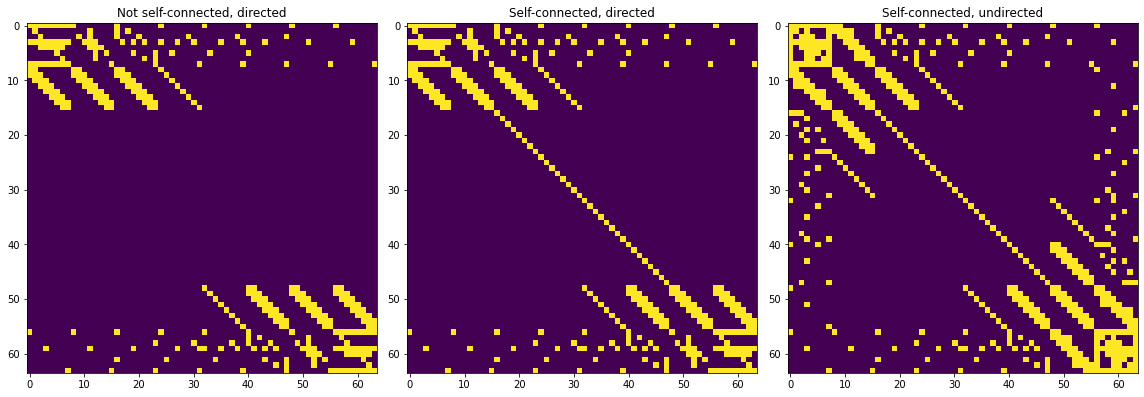

In [ ]:
piece_tracking = tf.cast(moves['piece_tracking'].loc[0], dtype=tf.int32)
piece_typing = tf.cast(moves['piece_typing'].loc[0], dtype=tf.int32)

plt.figure(figsize=(16, 6))
plt.subplot(1, 3, 1)
plt.title("Not self-connected, directed")
adj = create_adjacency_matrix(piece_tracking, piece_typing, self_connections=False, undirected=False)
plt.imshow(adj, interpolation='nearest')

plt.subplot(1, 3, 2)
plt.title("Self-connected, directed")
adj = create_adjacency_matrix(piece_tracking, piece_typing, self_connections=True, undirected=False)
plt.imshow(adj, interpolation='nearest')

plt.subplot(1, 3, 3)
plt.title("Self-connected, undirected")
adj = create_adjacency_matrix(piece_tracking, piece_typing, self_connections=True, undirected=True)
plt.imshow(adj, interpolation='nearest')

plt.tight_layout()
plt.show()

Connected components: 1
Sparisty: 13.04%


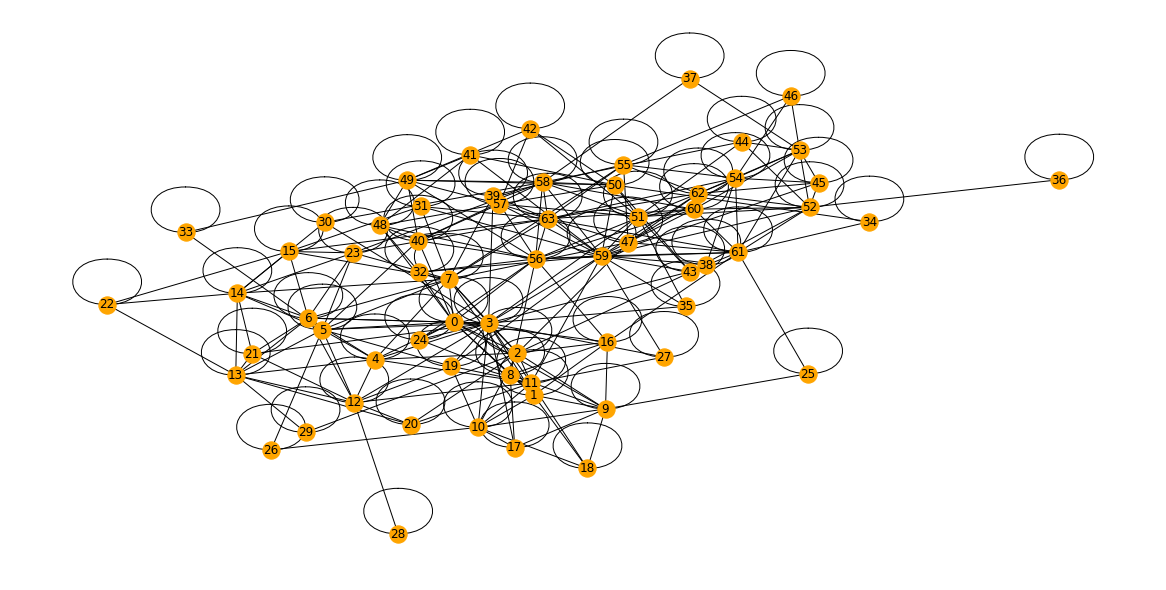

In [ ]:
print(f"Connected components: {len([i for i in nx.connected_components(nx.Graph(adj.numpy()))])}")
print(f"Sparisty: {100 * np.sum(adj) / 64 ** 2 :.2f}%")
plt.figure(figsize=(16, 8))
nx.draw(nx.Graph(adj.numpy()), with_labels=True, node_color='orange')
plt.show()

[0.98       0.974375   0.95750004 0.929375   0.89       0.839375
 0.77750003 0.70437497 0.62       0.52437496 0.41750002 0.29937494
 0.16999996 0.02937496 0.         0.        ]


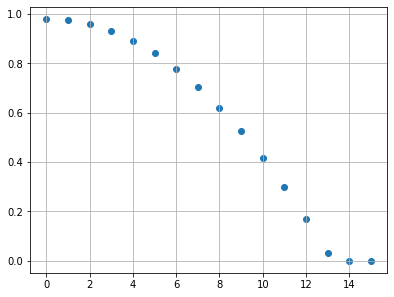

In [ ]:
@tf.function
def filter_by_ply_counts(x):
    return tf.maximum(0.0, 0.98 - tf.pow(0.075 * tf.cast(x, dtype=tf.float32), 2))


plt.scatter(np.arange(16), filter_by_ply_counts(np.arange(16)))
plt.grid()
print(filter_by_ply_counts(np.arange(16)).numpy())

In [ ]:
ds = get_dataset(data_file_path='data/boards_0000000.parquet', shuffle=False)
ds = ds.filter(lambda x: x['who_moves_next'] == 'w')  # Leave only white-moves-next positions
ds = ds.filter(lambda x: filter_by_ply_counts(x['ply_counter']) < tf.random.uniform([]))  # Filter out openings
ds = ds.map(prepare_features)
ds = ds.batch(1)

In [ ]:
features = []

for i, feat in enumerate(ds.take(250)):
    print(f"\rIteration: {i + 1}", end='')
    features += [feat]

Iteration: 250

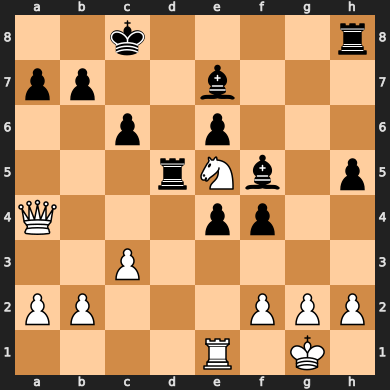

2k4r/pp2b3/2p1p3/3rNb1p/Q3pp2/2P5/PP3PPP/4R1K1 w - - 0 1


In [ ]:
idx = 20
coo_graph = features[idx]['coo_graph'].numpy()[0]
pos_feats = features[idx]['pos_feats'].numpy()[0]
glob_feats = features[idx]['glob_feats'].numpy()[0]
adj = get_adjacency_matrix_from_edge_list(64, coo_graph, directed=True)

b = chess.Board()
b.set_board_fen(piece_encoding_to_fen_code(pos_feats))
display(b)
print(b.fen())

In [ ]:
import cairosvg

with open("board.svg", mode='w') as f:
    f.write(chess.svg.board(b))

with open("board.svg", mode='rb') as f:
    cairosvg.svg2pdf(file_obj=f, write_to="board.pdf")

In [ ]:
import cairosvg

with open("board.svg", mode='w') as f:
    f.write(chess.svg.board(chess.Board()))

with open("board.svg", mode='rb') as f:
    cairosvg.svg2pdf(file_obj=f, write_to="board.pdf")

Connected components: 2, Sparsity: 11.23%
| white | black | K_cas | Q_cas | k_cas | q_cas | hm_cl | st_re |
|  1.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.16 |  0.00 |


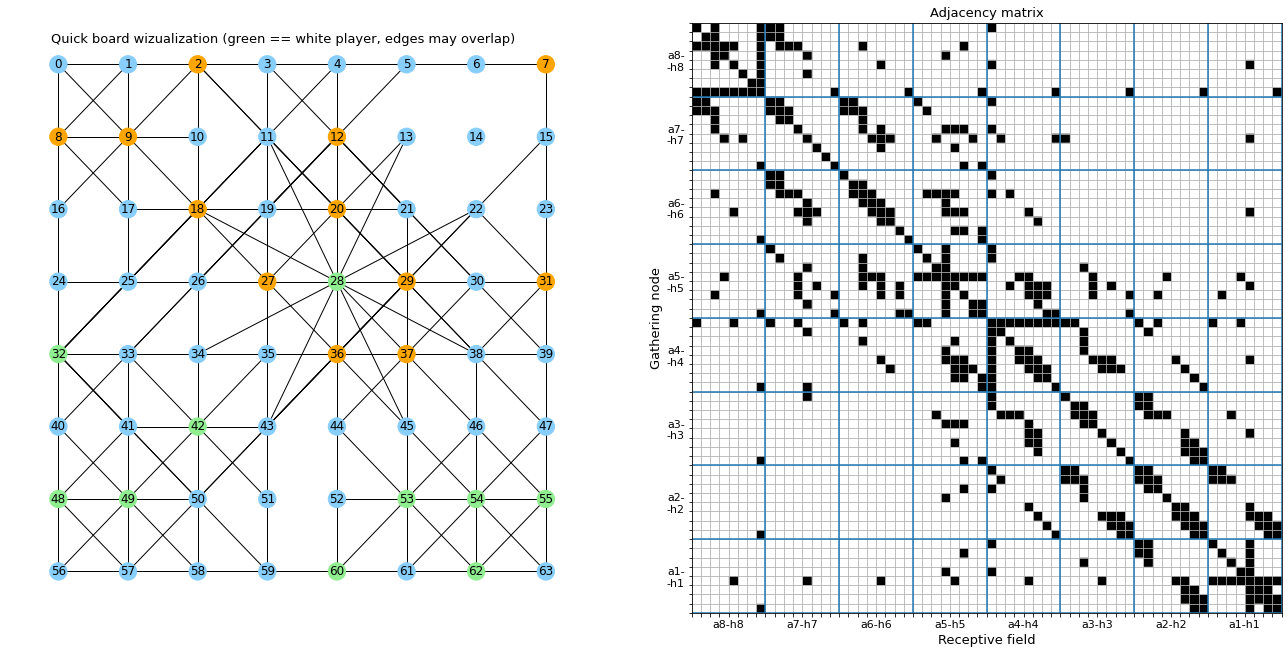

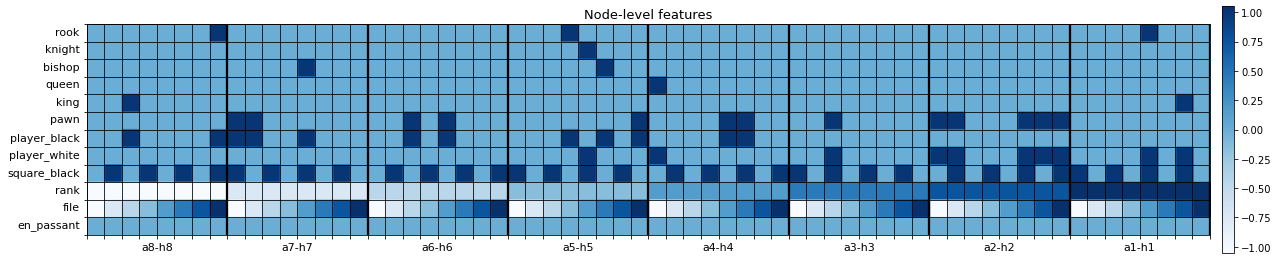

In [ ]:
print(f"Connected components: {len([i for i in nx.connected_components(nx.Graph(adj))])}, ", end='')
print(f"Sparsity: {100 * np.sum(adj) / 64 ** 2 :.2f}%")
print("| white | black | K_cas | Q_cas | k_cas | q_cas | hm_cl | st_re |")
print('|  ' + ' |  '.join([f"{i :.2f}" for i in glob_feats]) + ' |')
plt.figure(figsize=(18, 9))

plt.subplot(1, 2, 1)
plt.text(-0.1, 7.3, "Quick board wizualization (green == white player, edges may overlap)", fontsize=13)
g = nx.Graph(adj - np.eye(64))
mesh = np.mgrid[7:-1:-1, 0:8][::-1].reshape(2, -1).T
colors = np.array(['lightskyblue', 'orange', 'lightgreen'])[
    np.sum(pos_feats[:, 6:8].astype(np.int32) * np.array([1, 2]), axis=-1)]
nx.draw(g, pos=mesh, with_labels=True, node_color=colors)

plt.subplot(1, 2, 2)
plt.title("Adjacency matrix", fontsize=13)
plt.xlabel("Receptive field", fontsize=13)
plt.ylabel("Gathering node", fontsize=13)
mult = 8
plt.imshow(np.kron(adj, np.ones([mult, mult])), interpolation='bilinear', cmap='Greys')
plt.xticks(np.arange(-0.5, mult * 64, mult), [f"a{8 - (i // 8)}-h{8 - (i // 8)}" if i % 8 == 4 else '' for i in range(65)], fontsize=11)
plt.yticks(np.arange(-0.5, mult * 64, mult), [f"a{8 - (i // 8)}-\n-h{8 - (i // 8)}" if i % 8 == 4 else '' for i in range(65)], fontsize=11)
plt.grid()
plt.hlines(np.arange(-0.5 + mult * 8, mult * 64, mult * 8), xmin=-0.5, xmax=mult * 64 - 0.5, colors='tab:blue')
plt.vlines(np.arange(-0.5 + mult * 8, mult * 64, mult * 8), ymin=-0.5, ymax=mult * 64 - 0.5, colors='tab:blue')
plt.tight_layout()

plt.show()

pos_feat_labels = [
    "rook", "knight", "bishop", "queen", "king", "pawn",
    "player_black", "player_white", "square_black", "rank", "file", "en_passant"
]

plt.figure(figsize=(18, 3.75))
plt.title("Node-level features", fontsize=13)
mult = 8
plt.imshow(np.kron(pos_feats.T, np.ones([mult, mult])), cmap='Blues', interpolation='bilinear')
plt.colorbar(pad=0.01, fraction=0.05)
plt.xticks(np.arange(-0.5, mult * 64, mult), [f"a{8 - (i // 8)}-h{8 - (i // 8)}" if i % 8 == 4 else '' for i in range(65)], fontsize=11)
plt.yticks(np.arange(-0.5, mult * 12, mult), ['\n' + s for s in pos_feat_labels] + [''], fontsize=11)
plt.grid(c='k')
plt.vlines(np.arange(-0.5 + mult * 8, mult * 64, mult * 8), ymin=-0.5, ymax=mult * 12 - 0.5, colors='k', lw=2.25)
plt.tight_layout()

plt.show()

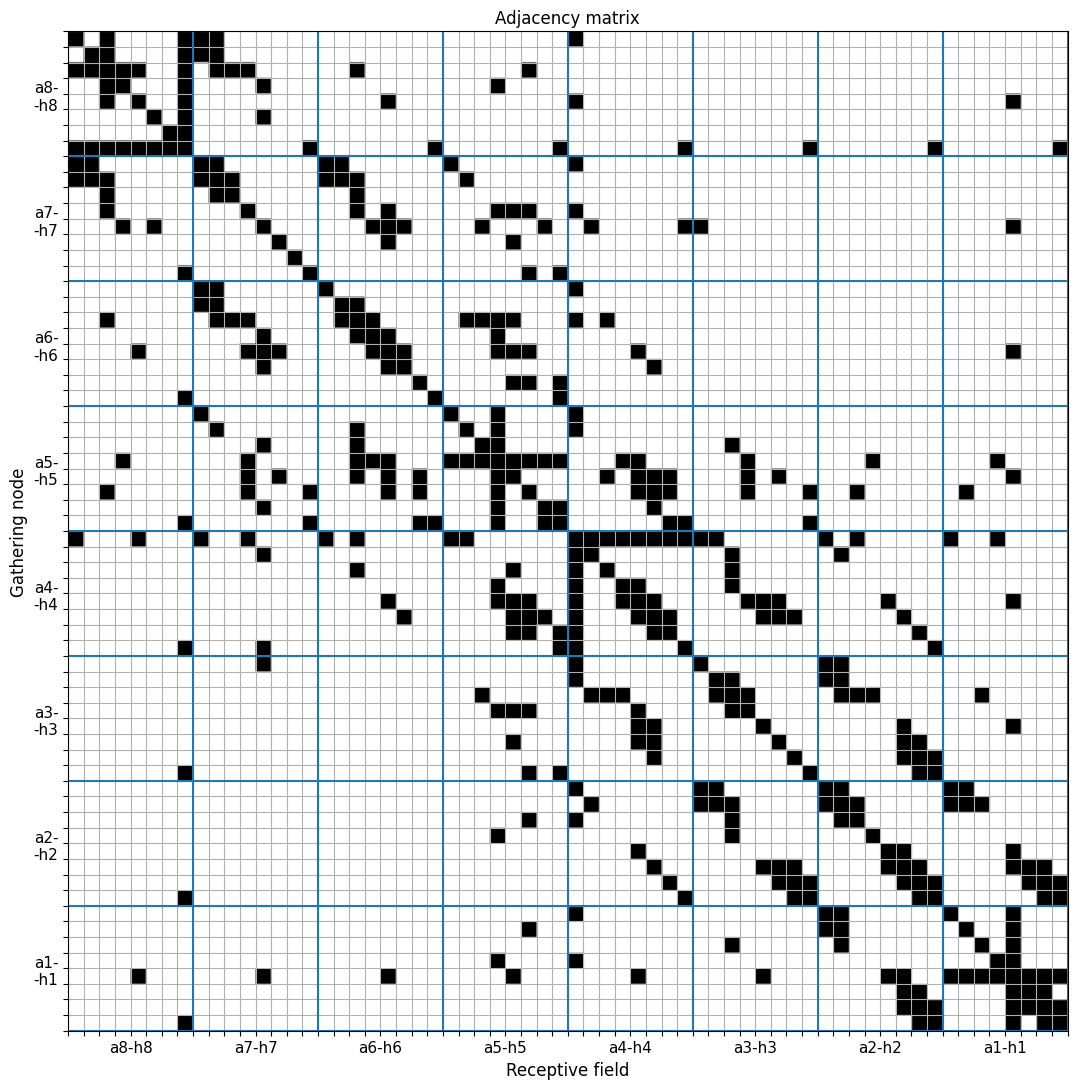

In [ ]:
plt.figure(figsize=(11, 11), dpi=100)

plt.title("Adjacency matrix", fontsize=12)
plt.xlabel("Receptive field", fontsize=12)
plt.ylabel("Gathering node", fontsize=12)
mult = 8
plt.imshow(np.kron(adj, np.ones([mult, mult])), interpolation='bilinear', cmap='Greys')
plt.xticks(np.arange(-0.5, mult * 64, mult), [f"a{8 - (i // 8)}-h{8 - (i // 8)}" if i % 8 == 4 else '' for i in range(65)], fontsize=11)
plt.yticks(np.arange(-0.5, mult * 64, mult), [f"a{8 - (i // 8)}-\n-h{8 - (i // 8)}" if i % 8 == 4 else '' for i in range(65)], fontsize=11)
plt.grid()
plt.hlines(np.arange(-0.5 + mult * 8, mult * 64, mult * 8), xmin=-0.5, xmax=mult * 64 - 0.5, colors='tab:blue')
plt.vlines(np.arange(-0.5 + mult * 8, mult * 64, mult * 8), ymin=-0.5, ymax=mult * 64 - 0.5, colors='tab:blue')

plt.tight_layout()
plt.savefig('adjacency_ex.pdf', format='pdf')

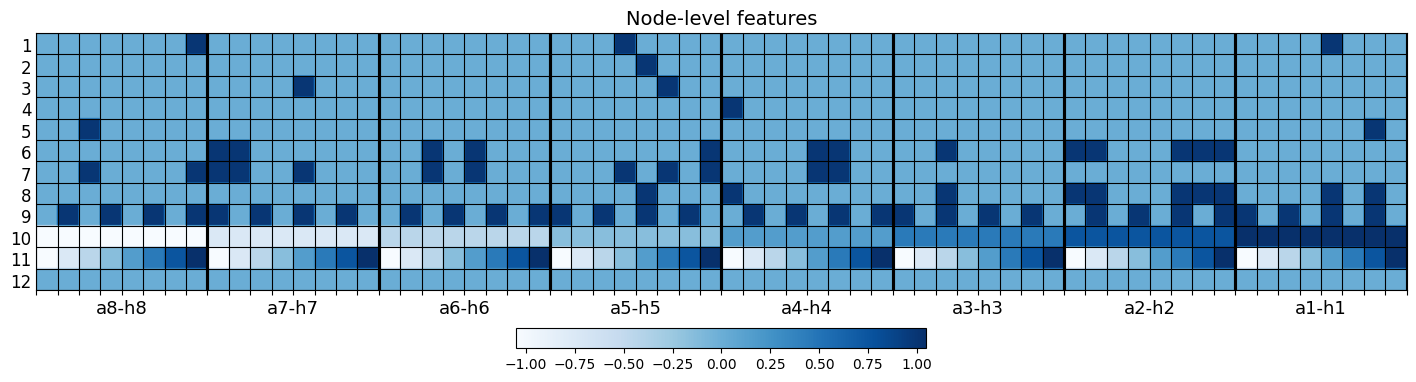

In [ ]:
pos_feat_labels = [
    "rook", "knight", "bishop", "queen", "king", "pawn",
    "piece black", "piece white", "sqr. black", "rank", "file", "en passant"
]
pos_feat_labels = [str(i) for i in range(1, 13)]

plt.figure(figsize=(15, 3.75), dpi=100)
plt.title("Node-level features", fontsize=14)
mult = 8
plt.imshow(np.kron(pos_feats.T, np.ones([mult, mult])), cmap='Blues', interpolation='bilinear')
plt.colorbar(pad=0.12, fraction=0.065, orientation="horizontal")
plt.xticks(np.arange(-0.5, mult * 64, mult), [f"a{8 - (i // 8)}-h{8 - (i // 8)}" if i % 8 == 4 else '' for i in range(65)], fontsize=13)
plt.yticks(np.arange(-0.5, mult * 12, mult), ['\n' + s for s in pos_feat_labels] + [''], fontsize=12)
plt.gca().tick_params(axis="y", direction="in", tick1On=False)
plt.grid(c='k')
plt.vlines(np.arange(-0.5 + mult * 8, mult * 64, mult * 8), ymin=-0.5, ymax=mult * 12 - 0.5, colors='k', lw=2.25)

plt.tight_layout()
plt.savefig('pos_feats_ex.pdf', format='pdf', bbox_inches='tight')